In [1]:
# DON'T FORGET TO ACTIVATE THE GPU when on google colab (Edit > Notebook settings)
from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

In [2]:
import numpy as np
import pylab as plt
import swyft

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Ntrain = 3000
Npars = 2

In [4]:
def model(v, sigma = 0.01):
    x = v + np.random.randn(Npars)*sigma
    return dict(x=x)

In [19]:
simulator = swyft.Simulator(model, Npars, sim_shapes = {"x": (Npars,)})
store = swyft.MemoryStore(simulator)
prior = swyft.Prior(lambda u: u*2-1, Npars)

Creating new store.


In [27]:
def round(bound, obs0):
    store.add(Ntrain, prior, bound = bound)
    store.simulate()
    dataset = swyft.Dataset(Ntrain, prior, store, bound = bound)
    post = swyft.Posteriors(dataset)
    post.add([(0, 1)], device=DEVICE)
    post.train([(0, 1)], max_epochs = 20)
    new_bound = post.truncate([(0, 1)], obs0)
    return post, new_bound

In [28]:
v0 = np.zeros(Npars)
obs0 = model(v0, sigma = 0.)

In [29]:
bound = None
for i in range(3):
    post, bound = round(bound, obs0)

Training: lr=0.001, Epoch=13, VL=0.05831
Bounds: Truncating...
Bounds: ...done. New volue is V=0.06072
Store: Adding 485 new samples to simulator store.
Training: lr=0.001, Epoch=20, VL=0.05846
Bounds: Truncating...
Bounds: ...done. New volue is V=0.00707
Store: Adding 2066 new samples to simulator store.
Training: lr=0.001, Epoch=7, VL=0.2547
Bounds: Truncating...
Bounds: ...done. New volue is V=0.007365


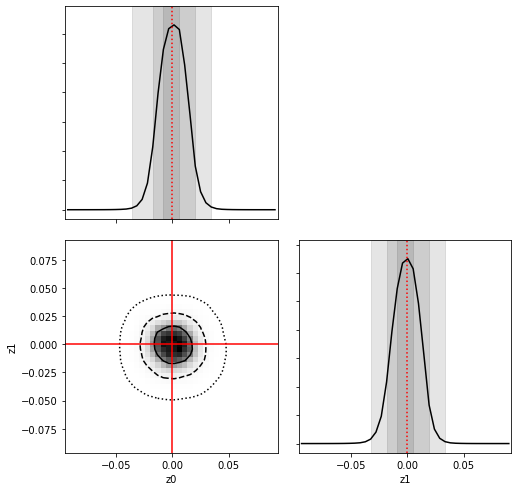

In [30]:
samples = post.sample(1000000, obs0)
swyft.plot_corner(samples, [0, 1], color='k', figsize = (8,8), truth=v0, bins = 40);